In [140]:
import pandas as pd
import numpy  as np
import seaborn
%pylab inline
FS  = (16,8)
FSS = (16,5)

Populating the interactive namespace from numpy and matplotlib


<br/><br/><br/>

## Load the data

In [153]:
dp   = lambda date: pd.datetime.strptime(date, '%d%b%Y')
 
data = pd.read_csv('Example Stocks.csv', parse_dates=['date'], date_parser=dp)

data.columns = list( map( lambda x : x.lower(), data.columns ) )

CocaCola     = (data['permno']==11308)
Apple        = (data['permno']==14593)
PhilipMorris = (data['permno']==92602)
Tesla        = (data['permno']==93436)

In [154]:
def plot_returns(companies, names):
    
    fig, ax1 = plt.subplots(1,1, figsize=FSS)
    
    for comp, name in zip(companies, names):
        df = data[comp]
        df.plot(y='ret', x='date', style='o', label=name+' monthly returns', ax=ax1)
        
    legend = plt.legend(frameon=True, loc=0)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    plt.ylim([-0.4,0.4])
    ax1.axhline(0, linestyle='--', color='grey')

<br/><br/><br/>

## Returns

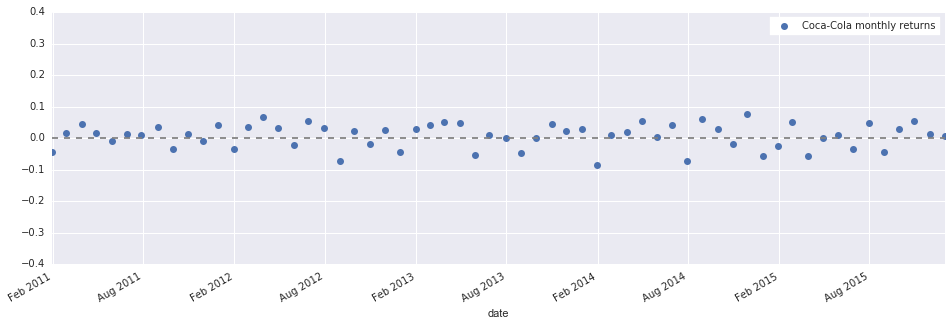

In [289]:
plot_returns([CocaCola], ['Coca-Cola'])

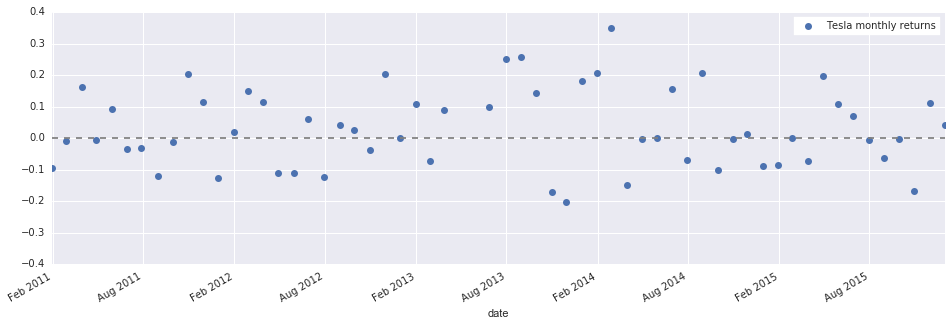

In [156]:
plot_returns([Tesla], ['Tesla'])

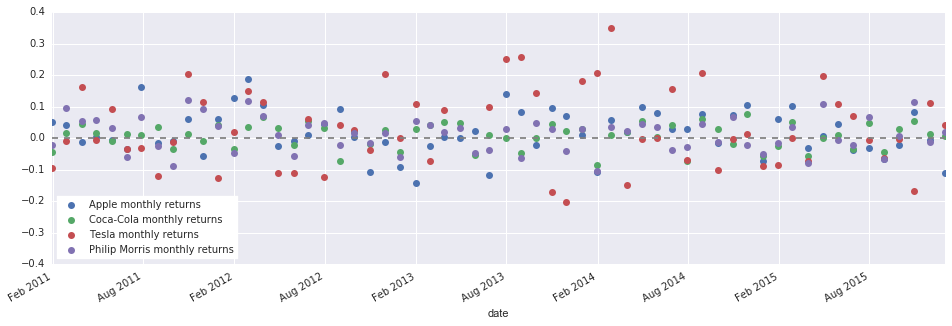

In [157]:
plot_returns([Apple, CocaCola, Tesla, PhilipMorris], ['Apple', 'Coca-Cola', 'Tesla', 'Philip Morris'])

<br/><br/><br/>

## Expected Return

In [248]:
ER = data.groupby('company')['ret'].mean()
ER.to_frame()

,ret
company,
APPLE,0.017509
COCA COLA,0.007645
PHILIP MORRIS,0.011852
TESLA MOTORS,0.048767


<br/><br/><br/>

## Standard Deviation

In [ ]:
data.set_index('company', inplace=1)
data['ER'] = ER
data.reset_index(inplace=1)
data['deviation'] = data['ret'] - data['ER']

In [282]:
def plot_cumulative(companies, names, colors=['b', 'r', 'g', 'purple']):
    if type(names) == str:
        names     = [names]
        companies = [companies]
    fig, (ax1) = plt.subplots(1,1, figsize=FSS)
    for company, name, color in zip(companies, names, colors):
        df = data[company].set_index('date')
        df['ret'].cumsum().plot(ax=ax1, label=name +' Cumulative Return', color=color)
        df['ER' ].cumsum().plot(ax=ax1, label=name +' Expected Cumulative Return', style=':', color=color)
    #ax1.set_ylim([-0.5, 3.5])
    ax1.legend(loc=0)

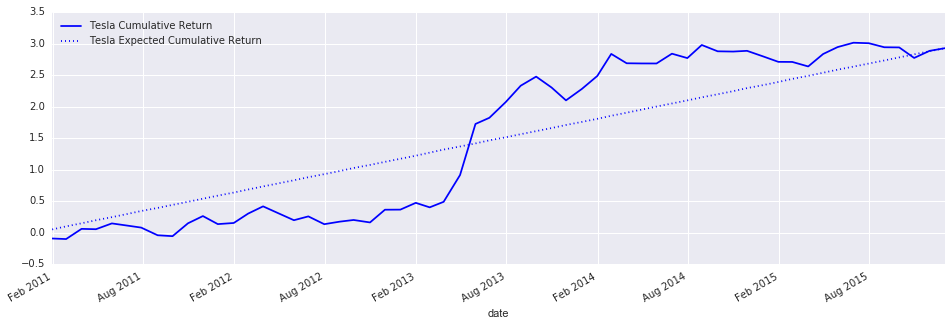

In [283]:
plot_cumulative(Tesla, 'Tesla')

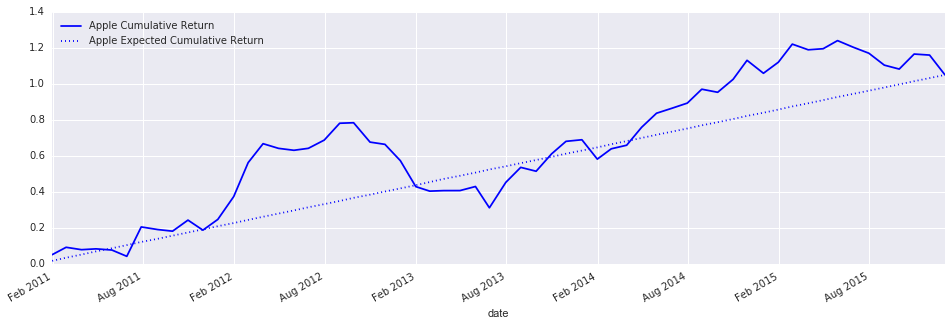

In [284]:
plot_cumulative(Apple, 'Apple')

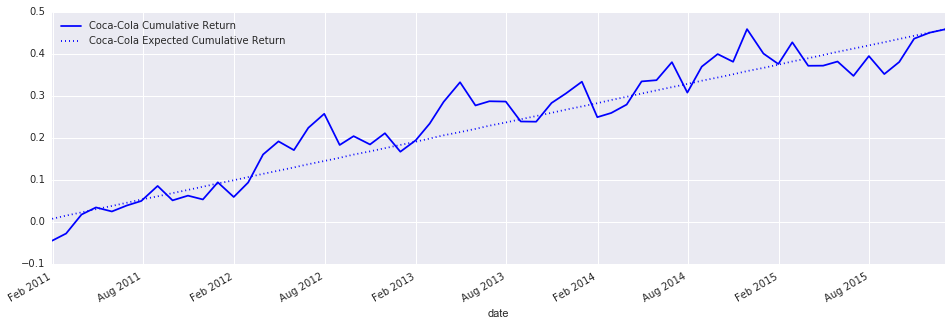

In [285]:
plot_cumulative(CocaCola, 'Coca-Cola')

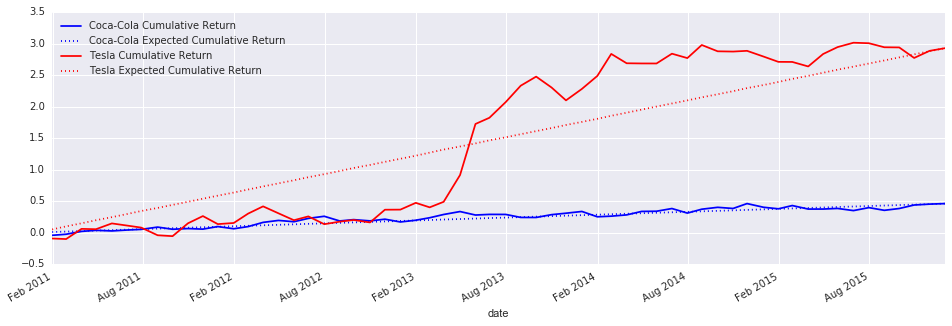

In [287]:
plot_cumulative([CocaCola, Tesla], ['Coca-Cola', 'Tesla'])

<br/><br/><br/>

## Expected Return VS Volatility

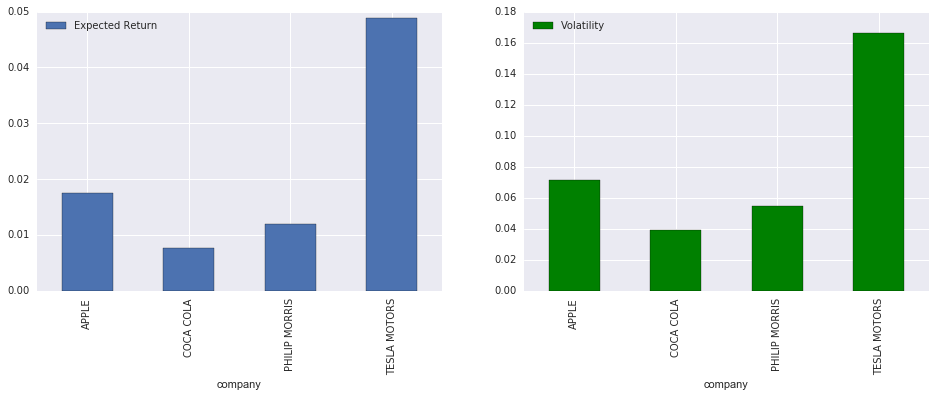

In [288]:
ER = data.groupby('company')['ret'].mean()
SD = data.groupby('company')['ret'].std()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=FSS)

ER.plot( kind='bar', ax=ax1, label='Expected Return' )
SD.plot( kind='bar', ax=ax2, label='Volatility', color='g' )

ax1.legend(loc=0); ax2.legend(loc=0)

<br/><br/><br/>

import matplotlib.gridspec as gridspec

fig, (ax1, space, ax2) = plt.subplots(3,1, gridspec_kw = {'height_ratios':[10,3,5]})

fig.figsize=(16, 15)

df = data[Tesla]

df.plot(y='ret', x='date', style='o', label='Monthly returns' , ax=ax1)
df.plot(y='deviation', x='date', kind='bar', figsize=FSS, ax=ax2, label='Deviation from the mean')

ax1.axhline( df['ER'].iloc[0], color='grey' )

ax1   .set_ylim([-0.4,0.4])
space .set_axis_off()
ax2   .set_axis_off()